<a href="https://colab.research.google.com/github/rpedram/data-science/blob/main/CapstonUAV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import sklearn.metrics
from imblearn.over_sampling import SMOTE

# Get the file path from Google Drive
file_path = '/content/drive/My Drive/Dataset/'

# **1. Importing Data**
df_exp1 = pd.read_csv(file_path+'experiment_vol1.csv')
df_exp2 = pd.read_csv(file_path+'experiment_vol2.csv')
df_exp3 = pd.read_csv(file_path+'experiment_vol3.csv')
df_geom1 = pd.read_csv(file_path+'geom_vol1.csv')
df_geom2 = pd.read_csv(file_path+'geom_vol2.csv')
df_geom3 = pd.read_csv(file_path+'geom_vol3.csv')

# Concat data in two sets
expframe=[df_exp1,df_exp2,df_exp3]
df_exp=pd.concat(expframe)
geoframe=[df_geom1,df_geom2,df_geom3]
df_geom=pd.concat(geoframe)
#Examine exp df
print("experimental df")
print(df_exp.head())
print(df_exp.info())
# Describe numerical variables to check for missing values, outliers, etc.
print(df_exp.describe())

# Examine the geom df
print("/n/n/nGeometric df")
print(df_geom.head())
print(df_geom.info())
# Describe numerical variables to check for missing values, outliers, etc.
print(df_geom.describe())


experimental df
    propellers_name   blades_name propellers_brand  number_of_blades  \
0  ance 8.5x6.0 - 2  ance 8.5x6.0             ance                 2   
1  ance 8.5x6.0 - 2  ance 8.5x6.0             ance                 2   
2  ance 8.5x6.0 - 2  ance 8.5x6.0             ance                 2   
3  ance 8.5x6.0 - 2  ance 8.5x6.0             ance                 2   
4  ance 8.5x6.0 - 2  ance 8.5x6.0             ance                 2   

   propellers_diameter  propellers_pitch  advanced_ratio_input  \
0                  8.5               6.0                 0.165   
1                  8.5               6.0                 0.214   
2                  8.5               6.0                 0.255   
3                  8.5               6.0                 0.301   
4                  8.5               6.0                 0.340   

   rpm_rotation_input  thrust_coefficient_output  power_coefficient_output  \
0              4000.0                     0.0993                    0.0539  

###Rename variables
to python naming convention
snake_case

In [ ]:
print(df_geom.columns)
print(df_exp.columns)
#Rename columns to snake case
df_exp.columns = (
    df_exp.columns
    .str.lower()  # Convert to lowercase
    .str.replace("'", "", regex=False)  # Remove apostrophe
    .str.replace(" ", "_", regex=False)  # Replace spaces with underscores
)
print(df_exp)
# Rename df_geom to snake case
df_geom.columns = (
    df_geom.columns
    .str.lower()  # Convert to lowercase
    .str.replace("'", "", regex=False)  # Remove apostrophe
    .str.replace(" ", "_", regex=False)  # Replace spaces with underscores
)
print(df_geom)


Index(['blades_name', 'propellers_brand', 'propellers_diameter',
       'propellers_pitch', 'adimensional_chord_-_c/r',
       'adimensional_radius_-_r/r', 'beta_-_angle_relative_to_rotation',
       'radius', 'chord'],
      dtype='object')
Index(['propellers_name', 'blades_name', 'propellers_brand',
       'number_of_blades', 'propellers_diameter', 'propellers_pitch',
       'advanced_ratio_input', 'rpm_rotation_input',
       'thrust_coefficient_output', 'power_coefficient_output',
       'efficiency_output'],
      dtype='object')


Save my concatenated files to csv for faster retrieval

In [ ]:
#Save to google drive
df_exp.to_csv('/content/drive/My Drive/Dataset/exp_prop_rev1.csv',index=False)
df_geom.to_csv('/content/drive/My Drive/Dataset/geom_prop_rev1.csv',index=False)

#Restart amending code from here

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import sklearn.metrics
from imblearn.over_sampling import SMOTE

# Get the file path from Google Drive
file_path = '/content/drive/My Drive/Dataset/'

# **1. Importing Data**
df_geom = pd.read_csv(file_path+'geom_prop_rev1.csv')
df_exp = pd.read_csv(file_path+'exp_prop_rev1.csv')

Mounted at /content/drive


In [ ]:
# **3. Calculate Radius and Chord Distributions**
df_geom['radius'] = df_geom['adimensional_radius_-_r/r'] * df_geom['propellers_diameter'] / 2  # Repeat for other files
df_geom['chord'] = df_geom['adimensional_chord_-_c/r'] * df_geom['propellers_diameter'] / 2     # Repeat for other files

# **4. Calculate Blade and Disc Areas**
def calculate_blade_area(df):
    df['blade_area'] = np.trapz(df['chord'], x=df['radius'])   # Use numpy.trapz
    return df

#df_geom = calculate_blade_area(df_geom.copy())  # Make copies to avoid changing the original
#Sending a copy of the DataFrame to the function is a common practice in programming,
# especially when working with mutable data structures like DataFrames.
#Trouble shoot function
df_new = calculate_blade_area(df_geom.copy())
print(df_new.head())
df_new.info()

print(df_geom.groupby('blades_name').head())

Calculate mean blade area in the df_geom df

#Fresh calculation

In [ ]:


def calculate_blade_area(df_geom, propeller_name):
    """Calculates the blade area for a single propeller in df_geom.

    Args:
        df_geom (pd.DataFrame): A DataFrame containing columns 'propeller_name', 'chord', and 'radius'.
        propeller_name (str): The name of the propeller to calculate the blade area for.

    Returns:
        float: The calculated blade area of the propeller.
    """

    blade_data = df_geom[df_geom['blades_name'] == propeller_name]
    chord = blade_data['chord'].to_numpy()
    radius = blade_data['radius'].to_numpy()
    blade_area = np.trapz(chord, x=radius)
    print(list[chord])
    print(propeller_name,"   ",blade_area)
    return blade_area


In [ ]:
#Test function is working before we run loop
print(calculate_blade_area(df_geom,'apce 10.0x5.0'))
#Function works fine

list[array([0.65 , 0.745, 0.865, 0.945, 0.985, 1.005, 1.   , 0.97 , 0.93 ,
       0.87 , 0.8  , 0.725, 0.64 , 0.56 , 0.48 , 0.405, 0.305, 0.205])]
apce 10.0x5.0     3.164375
3.164375


Lambda function for adding blade area. This has failed.

In [ ]:
# Add the blade area column unsing the lamba function
# Some how this approach didint work even after lots of debugging
#Explore in future. Most likely its the nulls due to blade geom of all blades missing from data
#df_exp['blade_area'] = df_exp['blades_name'].apply(lambda x: calculate_blade_area(df_geom, x))

In [ ]:
#Create a column in df_exp with blade area calculated from
# Create an empty list to store blade area values
blade_areas = []
for blade_name in df_exp['blades_name']:
    blade_area = calculate_blade_area(df_geom, blade_name)
    blade_areas.append(blade_area)

# Assign the calculated areas to the 'blade_area' column
df_exp['blade_area'] = blade_areas

Calulation of solidity parameter
blade_area/disc_area

This is a bad way to write code as creating columsn should be avoid. Got the job done and debugging was easy. Will improve code next time.

In [ ]:


def calculate_disc_area(df_exp):
    df_exp['disc_area'] = np.pi * (df_exp['propellers_diameter'] / 2) ** 2
    return df_exp

def calculate_solidity(df_exp):
    # Assuming you already have the 'blade_area' column in your DataFrame
    df_exp['solidity'] = df_exp['blade_area'] / df_exp['disc_area']
    return df_exp
df_exp = calculate_disc_area(df_exp.copy())  # Use a copy if you don't want to modify in-place
df_exp = calculate_solidity(df_exp.copy())


Analyse the consolidated experimental data
Removed all values there was no data of blade area and observations where efficiency is negative or zero. They are obviosusly wring anf will affect the model.

In [ ]:
df_exp.columns

def g(df_exp):
    # Count observations where blade_area is 0
    count_blade_area_0 = df_exp[df_exp['blade_area'] == 0].shape[0]

    # Count observations where efficiency output is negative or zero
    count_efficiency_negative_zero = df_exp[df_exp['efficiency_output'] <= 0].shape[0]

    # Create a new dataframe excluding observations with blade_area = 0 or efficiency output <= 0
    df_filtered = df_exp[(df_exp['blade_area'] != 0) & (df_exp['efficiency_output'] > 0)]

    # Print the counts and the filtered dataframe
    print(f"Count of observations with blade_area = 0: {count_blade_area_0}")
    print(f"Count of observations with efficiency output <= 0: {count_efficiency_negative_zero}")
    print(df_filtered)
    return df_filtered

df_filtered=g(df_exp.copy())

df_filtered.describe()


,number_of_blades,propellers_diameter,propellers_pitch,advanced_ratio_input,rpm_rotation_input,thrust_coefficient_output,power_coefficient_output,efficiency_output,blade_area,disc_area,solidity
count,10848.000000,10848.000000,10848.000000,10848.000000,10848.000000,10848.000000,10848.000000,10848.000000,10848.000000,10848.000000,10848.000000
mean,2.082412,9.119401,6.067119,0.443882,5922.520741,0.064612,0.047042,0.491462,2.959343,71.072050,0.045567
std,0.353612,2.707201,2.179017,0.204607,3139.804273,0.037475,0.021859,0.161066,1.333629,37.895669,0.015635
min,2.000000,2.244094,0.787402,0.044153,1500.000000,0.000000,0.008600,0.000175,0.338451,3.955234,0.032308
25%,2.000000,9.000000,4.700000,0.282052,4031.000000,0.034200,0.031100,0.382000,2.413800,63.617251,0.038348
50%,2.000000,10.000000,6.000000,0.438000,5053.000000,0.063689,0.044700,0.522543,3.176875,78.539816,0.040720
75%,2.000000,11.000000,7.000000,0.589000,6042.000000,0.092200,0.058400,0.621000,3.644369,95.033178,0.047237
max,4.000000,19.000000,13.000000,1.140286,25065.000000,0.235876,0.165775,0.762000,9.160375,283.528737,0.150436


I want to save my df filtered to new file to load faster. to exp_prop_filter


In [ ]:
#Save to google drive
df_filtered.to_csv('/content/drive/My Drive/Dataset/exp_prop_filter.csv',index=False)
df_exp=df_filtered  #continue with same naming convention to avoid confusion

#Data danalysis and deduction

In [ ]:
df_exp.columns

Index(['propellers_name', 'blades_name', 'propellers_brand',
       'number_of_blades', 'propellers_diameter', 'propellers_pitch',
       'advanced_ratio_input', 'rpm_rotation_input',
       'thrust_coefficient_output', 'power_coefficient_output',
       'efficiency_output', 'blade_area', 'disc_area', 'solidity'],
      dtype='object')

In [ ]:
# This runs descriptive analysis on the df_noorm data frame
import scipy.stats as stats
df_exp.columns

# Identify numerical columns for analysis
#Exclude your binaries . they got reset to zero with automated Winsorization

exclude_list=[]
numerical_columns = df_exp.select_dtypes(include=['int64', 'float64']).columns.difference(exclude_list)

#numerical_columns = df.select_dtypes(include=['int64', 'float64']) ---- this didnt work
# Careful with outlier check on binary columns. It will set them to zero
# Create a function for outlier detection and treatment
def detect_and_treat_outliers(column):
    """
    Detects outliers in a numerical column using IQR and removes or winsorizes them.

    Args:
        column: The numerical column to analyze.

    Returns:
        The cleaned column with outliers removed or winsorized.
    """

    # Calculate IQR and quantiles
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1

    # Identify potential outliers (values beyond 1.5 IQR from quartiles)
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = column[(column < lower_bound) | (column > upper_bound)]


    # 1. Winsorize outliers (replace with nearest non-outlier value)
    # Choosing winsorize with clip method as I want the shape of my data frame unchanged with no nulls.
    # Another method we can use the matstats library the command is slick!
    #from scipy.stats import mstats
    #cleaned_column = mstats.winsorize(df[column_to_winsorize], limits=(lower_limit, upper_limit))

    cleaned_column = column.clip(lower_bound, upper_bound,axis=0)

    return cleaned_column
clean_df=pd.DataFrame()
# Iterate through numerical columns and visualize distributions
#Basic plot for every column descriptive anaysis.
#Eyeballing the data is much better I feel and faster. Gimmmick
for column in numerical_columns:
    print(f"\nAnalyzing column: {column}")

    # Create box plot
    plt.figure(figsize=(8, 6))
    df_exp[column].plot(kind='box')
    plt.title(f"Box Plot for {column}")
    plt.show()

    # Create histogram
    plt.figure(figsize=(8, 6))
    df_exp[column].hist(bins=20)
    plt.title(f"Histogram for {column}")
    plt.show()

    # Detect and treat outliers (use the chosen method from the function)

    clean_df[column] = detect_and_treat_outliers(df_exp[column])
    #df[column] = detect_and_treat_outliers(df[column])
clean_df.info()
print('cleaned df   ',clean_df.describe())
print('Original df to compare',df_exp.describe())

# Save the cleaned DataFrame if needed
# cleaned_df.to_csv('cleaned_data.csv', index=False)


cleaned df           number_of_blades  propellers_diameter  propellers_pitch  \
count           10848.0         10848.000000      10848.000000   
mean                2.0             9.377212          6.014024   
std                 0.0             1.922593          2.002791   
min                 2.0             6.000000          1.250000   
25%                 2.0             9.000000          4.700000   
50%                 2.0            10.000000          6.000000   
75%                 2.0            11.000000          7.000000   
max                 2.0            14.000000         10.450000   

       advanced_ratio_input  rpm_rotation_input  thrust_coefficient_output  \
count          10848.000000        10848.000000               10848.000000   
mean               0.443851         5491.007144                   0.064540   
std                0.204510         1638.306977                   0.037229   
min                0.044153         1500.000000                   0.000000   
2

based on above data i have no outliers and no outlier application is required as there is no difference on the main parameters when outlier treatment in applied.

#Normalisation of data
The data will require to be normalised to make a comparison and avoid bias of magnitude. Applying the minmax scalar

In [ ]:
#Apply Min Max scalar
from sklearn.preprocessing import MinMaxScaler
# Create a min-max scaler object
norm_fields=['propellers_diameter', 'propellers_pitch',
       'advanced_ratio_input', 'rpm_rotation_input',
       'thrust_coefficient_output', 'power_coefficient_output',
       'efficiency_output', 'blade_area', 'disc_area', 'solidity']
scaler = MinMaxScaler()

# Fit and transform the dataframe
df_norm = scaler.fit_transform(df_exp[norm_fields])

# Convert the numpy array to a dataframe
df_norm = pd.DataFrame(df_norm, columns=norm_fields)

# Print the dataframe
print(df_norm)
df_exp.columns
df_norm.describe()

Index(['propellers_name', 'blades_name', 'propellers_brand',
       'number_of_blades', 'propellers_diameter', 'propellers_pitch',
       'advanced_ratio_input', 'rpm_rotation_input',
       'thrust_coefficient_output', 'power_coefficient_output',
       'efficiency_output', 'blade_area', 'disc_area', 'solidity'],
      dtype='object')

The number of blades fiels is not being used in the corelation as the data is heavily skewed.

In [ ]:
df_norm.drop('number_of_blades', axis=1, inplace=True)

Correlation

                           propellers_diameter  propellers_pitch  \
propellers_diameter                   1.000000          0.818150   
propellers_pitch                      0.818150          1.000000   
advanced_ratio_input                  0.081445          0.235817   
rpm_rotation_input                   -0.635396         -0.571680   
thrust_coefficient_output            -0.086620          0.085463   
power_coefficient_output             -0.234997          0.085644   
efficiency_output                     0.278891          0.357641   
blade_area                            0.933882          0.772099   
disc_area                             0.960886          0.801378   
solidity                             -0.552638         -0.446997   

                           advanced_ratio_input  rpm_rotation_input  \
propellers_diameter                    0.081445           -0.635396   
propellers_pitch                       0.235817           -0.571680   
advanced_ratio_input                  

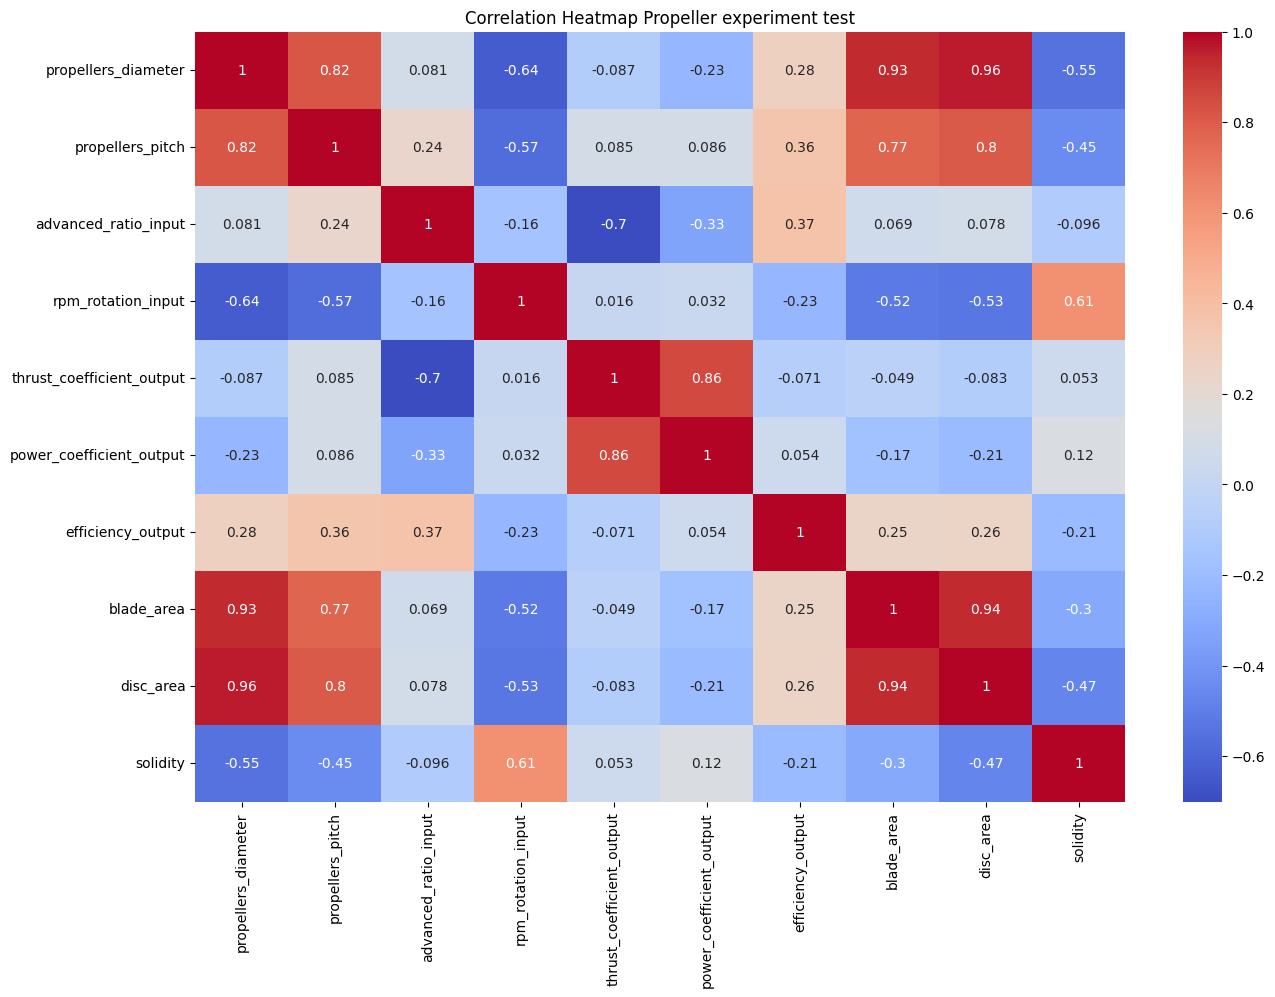

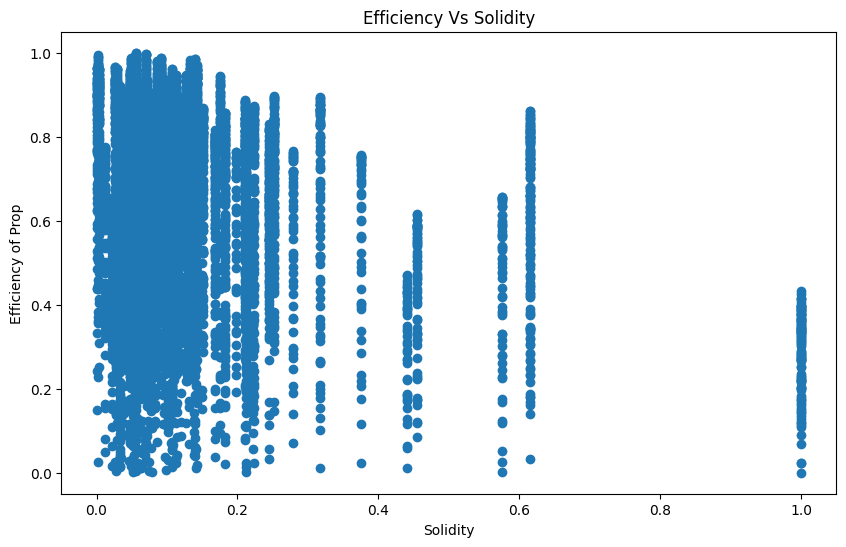

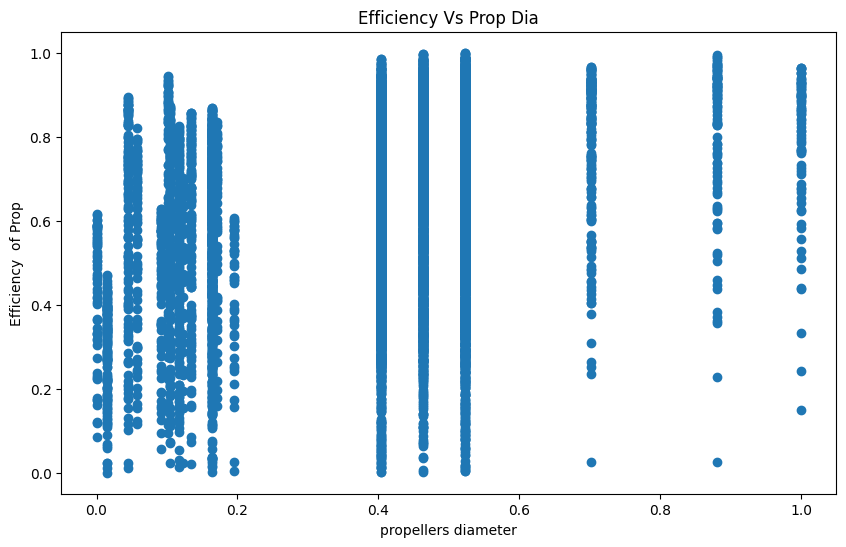

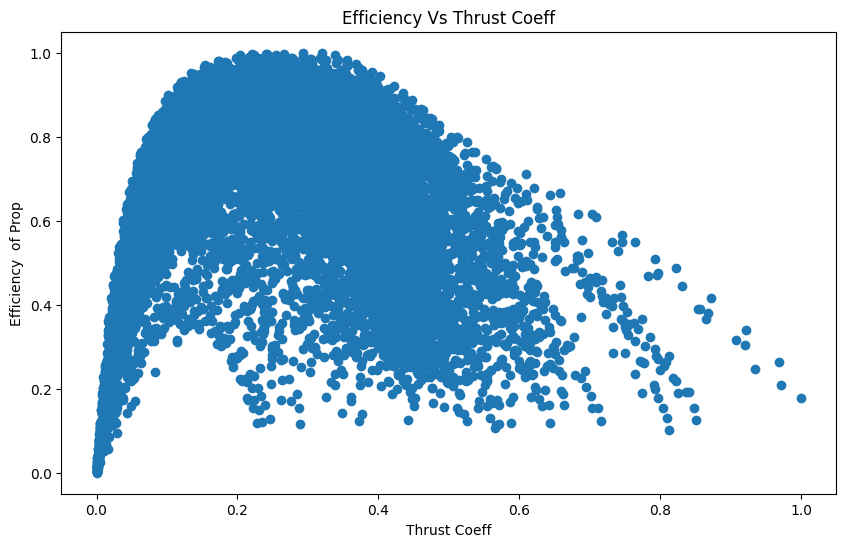

In [ ]:
df_norm.columns
# Calculate correlation matrix
correlation = df_norm.corr()
print(correlation)

# Create the heatmap using Seaborn for better control and colorbar
plt.figure(figsize=(15, 10))  # Set the figure size (adjust as needed)
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap Propeller experiment test")
plt.show()


# Analyze numerical features, identify patterns. Understand distribution Efficiency of prop
plt.figure(figsize=(10, 6))  #  Width=10 inches, Height=6 inches
# Visualize the impact of various factors on efficiency
#Eff vs Solidity
plt.scatter(df_norm['solidity'], df_norm['efficiency_output'])
# Add labels and title
plt.xlabel('Solidity')
plt.ylabel('Efficiency of Prop')
plt.title('Efficiency Vs Solidity')
plt.show()

# Efficiency vs Propeller Dia
plt.figure(figsize=(10, 6))  #  Width=10 inches, Height=6 inches
# Visualize the impact of factors on efficiency
plt.scatter(df_norm['propellers_diameter'], df_norm['efficiency_output'])
# Add labels and title
plt.xlabel('propellers diameter')
plt.ylabel('Efficiency  of Prop')
plt.title('Efficiency Vs Prop Dia')
plt.show()

# Efficiency vs Thrust Coeff
plt.figure(figsize=(10, 6))  #  Width=10 inches, Height=6 inches
# Visualize the impact of factors on efficiency
plt.scatter(df_norm['thrust_coefficient_output'], df_norm['efficiency_output'])
# Add labels and title
plt.xlabel('Thrust Coeff')
plt.ylabel('Efficiency  of Prop')
plt.title('Efficiency Vs Thrust Coeff')
plt.show()

As mt results are satisfactory saving my normalised df

In [ ]:
#Save to google drive
df_norm.to_csv('/content/drive/My Drive/Dataset/exp_prop_norm.csv',index=False)

Model building
First I add the number of blades colum to my normalised df


In [ ]:
df_exp.columns

Index(['propellers_name', 'blades_name', 'propellers_brand',
       'number_of_blades', 'propellers_diameter', 'propellers_pitch',
       'advanced_ratio_input', 'rpm_rotation_input',
       'thrust_coefficient_output', 'power_coefficient_output',
       'efficiency_output', 'blade_area', 'disc_area', 'solidity'],
      dtype='object')

In [ ]:
#Concat was givinf NaN values so index reset
df_norm.reset_index(drop=True, inplace=True)
df_exp.reset_index(drop=True, inplace=True)


In [ ]:
df_conc = pd.concat([df_norm, df_exp['number_of_blades']], axis=1)

print(df_conc.tail())
#goinf to rename my df as df_model for next phase
df_model=df_conc
df_model.head()
df_model.columns

,propellers_diameter,propellers_pitch,advanced_ratio_input,rpm_rotation_input,efficiency_output,blade_area,disc_area,solidity,number_of_blades
0,0.403195,0.344939,0.103862,0.106387,0.401437,0.224346,0.213404,0.034896,2
1,0.403195,0.344939,0.142179,0.106387,0.486759,0.224346,0.213404,0.034896,2
2,0.403195,0.344939,0.180495,0.106387,0.561579,0.224346,0.213404,0.034896,2
3,0.403195,0.344939,0.209689,0.106387,0.611459,0.224346,0.213404,0.034896,2
4,0.403195,0.344939,0.258041,0.106387,0.669215,0.224346,0.213404,0.034896,2


#Reducing dimensionality
I will Drop features with poor correlation to efficiency
I am dropping thrust coeff and power coeff to reduce dimensionality

In [ ]:
df_model.drop('power_coefficient_output', axis=1, inplace=True)
df_model.drop('thrust_coefficient_output', axis=1, inplace=True)

Now filter the df to only include two blade data

In [ ]:
df_filtered = df_model[df_model['number_of_blades'] == 2]
print(df_filtered.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10222 entries, 0 to 10847
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   propellers_diameter   10222 non-null  float64
 1   propellers_pitch      10222 non-null  float64
 2   advanced_ratio_input  10222 non-null  float64
 3   rpm_rotation_input    10222 non-null  float64
 4   efficiency_output     10222 non-null  float64
 5   blade_area            10222 non-null  float64
 6   disc_area             10222 non-null  float64
 7   solidity              10222 non-null  float64
 8   number_of_blades      10222 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 798.6 KB
None


##Model 1
Building Model1 without imputation

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
# ... other imports for evaluation metrics and visualizations



#  Preprocessing & Feature/Target Separation
X = df_filtered.drop('efficiency_output', axis=1)  # Input features
y = df_filtered['efficiency_output']  # Target variable

#  Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Building (we have three scenarios) The imputations isnt likely to help

## Model 1: No imputation
model1 = GradientBoostingRegressor()
model1.fit(X_train, y_train)



# 6. Evaluation on Propellers with Other Blade Counts
df_other_blades = df_model[df_model['number_of_blades'] != 2]
X_other = df_other_blades.drop('efficiency_output', axis=1)
Y_other=df_other_blades['efficiency_output']
# ... Impute if model2 used imputation
# ... Remove solidity column if model3 is used

predictions1 = model1.predict(X_other)


print('Mean square error of model 1 no imoutation  is :',mean_squared_error(Y_other, predictions1))

r_squared = model1.score(X_other,Y_other)  # Use your test set
print("R-squared on model 1 No imputation is:", r_squared)




Mean square error of model 1 no imoutation  is : 0.016250561013118572


##Model 2 with imputation

In [ ]:
## Model 2: With Imputation
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
model2 = GradientBoostingRegressor()
model2.fit(X_train_imputed, y_train)
# Prediction using the other data set
predictions2 = model2.predict(X_other)


r_squared = model2.score(X_other,Y_other)  # Use your test set
print("R-squared on model 2 No imputation is:", r_squared)

print('Mean square error of model 2-with imoutation  is :',mean_squared_error(Y_other, predictions2))

Mean square error of model 2-with imoutation  is : 0.01625056101311857


##Model 3 : dropping solidity

In [ ]:

## Model 3: Without Solidity
X_train_no_solidity = X_train.drop('solidity', axis=1)
X_test_no_solidity = X_test.drop('solidity', axis=1)
model3 = GradientBoostingRegressor()
model3.fit(X_train_no_solidity, y_train)

# Prediction using other data set with more than 2 blades
X_other_drop_solidity=X_other.drop('solidity',axis=1)

predictions3 = model3.predict(X_other_drop_solidity)
r_squared = model3.score(X_other_drop_solidity,Y_other)  # Use your test set
print("R-squared on model 1 No imputation is:", r_squared)

print('Mean square error of model 3 no solidity is :',mean_squared_error(Y_other, predictions3))


Mean square error of model 3 no solidity is : 0.01858482411199778


#Data Visualisation
Plotting the model R square and MSE on bars and scatter plot for predition of all models

In [ ]:



models = ['No Imputation', 'With Imputation', 'No Solidity']
r_squared = [0.5255, 0.5255, 0.475]
mse = [0.01625, 0.01625, 0.01858]

# Bar Plot for R-squared
plt.figure(figsize=(8, 6))
sns.barplot(x=models, y=r_squared)
plt.xlabel('Model')
plt.ylabel('R-squared')
plt.title('R-squared Comparison')
plt.show()

# Similar bar plots for MSE and MAE
# Bar Plot for R-squared
plt.figure(figsize=(8, 6))
sns.barplot(x=models, y=mse)
plt.xlabel('Model')
plt.ylabel('Mean Sq Error')
plt.title('MSE Comparison')
plt.show()


# Scatterplot: Actual vs. Predicted For model 1
plt.figure(figsize=(8, 6))
plt.scatter(Y_other, predictions1)
plt.xlabel('Actual Efficiency')
plt.ylabel('Predicted Efficiency')
plt.title('Actual vs. Predicted (No Imputation Model)')
plt.show()

# Scatterplot: Actual vs. Predicted For model 2
plt.figure(figsize=(8, 6))
plt.scatter(Y_other, predictions2)
plt.xlabel('Actual Efficiency')
plt.ylabel('Predicted Efficiency')
plt.title('Actual vs. Predicted (With Imputation Model)')
plt.show()

# Scatterplot: Actual vs. Predicted For model 3
plt.figure(figsize=(8, 6))
plt.scatter(Y_other, predictions3)
plt.xlabel('Actual Efficiency')
plt.ylabel('Predicted Efficiency')
plt.title('Actual vs. Predicted (No Solidity)')
plt.show()

arr3=(Y_other, predictions3)
type(arr3)


tuple